In [1]:
# leba3207

import os, ssl

import sklearn
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import DBSCAN
from itertools import product

In [2]:
# Chargement d'un ensemble de données de faces de personnages connus
from sklearn.datasets import fetch_lfw_people

In [3]:
# fix unverified MacOs ssl certificates
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
        getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
faces = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [5]:
# format des images et nombres de clusters
print("Format des images: {}".format(faces.images.shape))
print("Nombre de classes: {}".format(len(faces.target_names)))

Format des images: (3023, 87, 65)
Nombre de classes: 62


In [6]:
# nombre de données par cluster
number_target_per_face = np.bincount(faces.target)
for i, (nb, nom) in enumerate(zip(number_target_per_face, faces.target_names)):
    print("{0:25} {1:3}".format(nom, nb), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

<ipython-input-7-59f2124b0a46>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


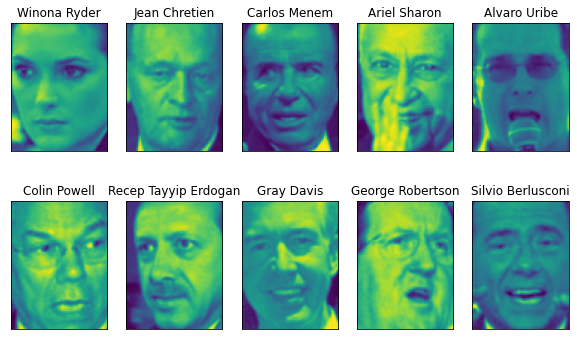

In [7]:
# Affichage des 10 premières faces
fig, axes = plt.subplots(2, 5, figsize=(10, 6), subplot_kw={'xticks': (), 'yticks': ()})
for nom, image, ax in zip(faces.target, faces.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(faces.target_names[nom])
fig.show()

# 1. Balancement des données

In [8]:
data = pd.DataFrame(faces.data)
target = pd.Series(faces.target)

In [9]:
filtered_data = pd.DataFrame()
filtered_target = pd.Series(dtype='int32')

positions = []
for i in range(len(faces.target_names)):
    # retrieve first forty indexes of target associated
    positions.extend(np.where(faces.target == i)[0][:40])

filtered_data = data.iloc[positions, :]
filtered_target = target[positions]

filtered_data = filtered_data.sort_index(axis=0)
filtered_target = filtered_target.sort_index(axis=0)

On récupère les 40 premières images (faces.data) pour chaque personne dans filtered_data ainsi que les cibles 
associées de la même manière (faces.target).

# 2. Réduction de la dimensionalité des données

In [10]:

pca = PCA(n_components=100, whiten=True, random_state=0)
reduced_data = pd.DataFrame(pca.fit_transform(filtered_data))

# 3. Analyse avec K-Means
## a. Méthode Elbow

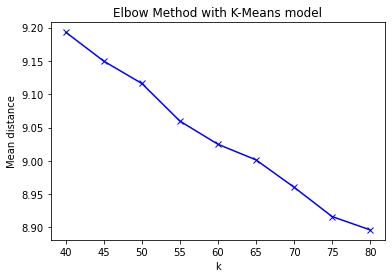

In [11]:
K = range(40, 85, 5)
mean_distances = []
for k in K:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(reduced_data)
    dist_to_best_centroid = np.min(cdist(reduced_data, model.cluster_centers_, 'euclidean'), axis=1)
    mean_distances.append(sum(dist_to_best_centroid) / reduced_data.shape[0])

plt.plot(K, mean_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Mean distance')
plt.title('Elbow Method with K-Means model')
plt.show()

La méthode Elbow permet en théorie de sélectionner le nombre de clusters optimal en entraînant le modèle K-means selon 
différents nombres de voisins k. 
Grâce au graphe ci-dessus, on peut observer deux légers coudes révèlant des zones propices à donner de bon clustering. 
On observe un premier coude aux alentours de k=55/60 et un autre à k=75.
On pourrait alors envisager de s'intéresser particulièrement aux clusters des modèles K-means pour k=55/60 et k=75.

## b. Approche de validation croisée

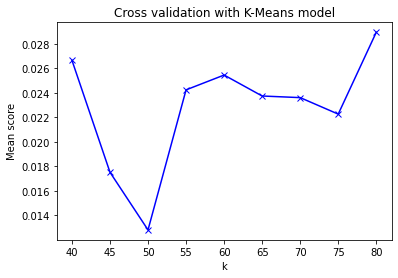

In [12]:

mean_scores = []
scorer = make_scorer(adjusted_rand_score)

for k in K:
    model = KMeans(n_clusters=k, random_state=0)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cv_results = cross_validate(model, reduced_data, filtered_target, cv=cv, scoring=scorer, n_jobs=-1)
    mean_scores.append(np.mean(cv_results['test_score']))

plt.plot(K, mean_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Mean score')
plt.title('Cross validation with K-Means model')
plt.show()

La mesure de score ARI nous informe sur la similarité entre deux clusterings en comparant les prédictions de 
clusters du modèle et les cibles. Cela permet donc de déterminer si le modèle de clustering est performant.

Grâce à la validation croisée, on détermine que le modèle K-means pour k=80 présente le score ARI moyen le plus élevé. 
Cependant, ce score (0.03) se révèle être quand même bas, ce qui démontre pas une performance élevée du modèle. 

On dénote aussi que, lorsque le random_state n'est pas fixe, alors les résultats de la validation croisée se révèlent 
être très différents les uns des autres. On peut donc facilement imaginer que le modèle est peu robuste, et se demander
si K-means est vraiment pertinent pour nos données.

# 4. Analyse avec DBSCAN
## a. Utilisation du coefficient de silhouette

In [13]:

pairwise_dist = squareform(pdist(reduced_data, 'euclidean'))
best_params = {'score': 0}
score_clusters = pd.DataFrame()
nb_clusters = pd.DataFrame()
for i, (ep, min_sample) in enumerate(product(range(5, 16), range(1, 11))):
    model = DBSCAN(eps=ep, min_samples=min_sample, n_jobs=-1)
    pred = model.fit_predict(reduced_data, filtered_target)
    nb_clusters.at[ep, min_sample] = len(np.unique(pred)) - 1

    if len(np.unique(pred)) != 1:
        score = silhouette_score(pairwise_dist, pred)
        score_clusters.at[ep, min_sample] = score

        if score > best_params.get('score'):
            best_params['eps'] = ep
            best_params['min_sample'] = min_sample
            best_params['score'] = score
            best_params['model'] = model

In [14]:
print('Score des clusters en fonction de eps (ligne) et min_sample (colonne):')
score_clusters

Score des clusters en fonction de eps (ligne) et min_sample (colonne):


,1,2,3,4,5,6,7,8,9,10
5,-0.000320,-0.136953,-0.136953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.001693,-0.257431,-0.126758,-0.123963,NaN,NaN,NaN,NaN,NaN,NaN
7,0.000168,-0.395645,-0.145035,-0.149195,-0.149195,-0.139820,NaN,NaN,NaN,NaN
8,-0.033894,-0.349831,-0.118995,-0.048117,-0.048134,-0.064177,-0.068808,0.106772,0.110513,0.108859
9,-0.081030,-0.272792,-0.037814,0.228535,0.230634,0.230122,0.230014,0.229573,0.227029,0.226774
10,-0.098156,-0.125885,0.028908,0.354101,0.354535,0.354193,0.353503,0.353296,0.353248,0.353293
11,-0.027818,0.174916,0.449043,0.448091,0.447598,0.447507,0.448096,0.447877,0.447667,0.447844
12,0.156003,0.349398,0.509622,0.509622,0.509622,0.510340,0.510609,0.510609,0.510609,0.510883
13,0.273778,0.543670,0.543670,0.543670,0.543670,0.543670,0.543670,0.543670,0.543670,0.543670
14,0.412413,0.541255,0.584863,0.584863,0.584863,0.584863,0.584863,0.584863,0.584863,0.584863


In [15]:
print('Nombre de clusters en fonction de eps (ligne) et min_sample (colonne):')
nb_clusters

Nombre de clusters en fonction de eps (ligne) et min_sample (colonne):


,1,2,3,4,5,6,7,8,9,10
5,1912.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1904.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1860.0,36.0,12.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0
8,1623.0,32.0,5.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0
9,1197.0,25.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10,712.0,21.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
11,385.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
12,204.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
13,115.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
14,52.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [16]:
print(f'Les paramètres présentant les meilleurs silhouette score sont: eps {best_params.get("eps")} et min_sample '
      f'{best_params.get("min_sample")}')
print(f'Le nombre de clusters trouvé est de {len(np.unique(model.labels_)) - 1}')

Les paramètres présentant les meilleurs silhouette score sont: eps 15 et min_sample 3
Le nombre de clusters trouvé est de 1


Le coefficient de silhouette permet de mesurer la qualité de partition des clusters établis. 
On note que celui-ci devient de plus en plus élevé pour des eps et min_samples de plus en plus grands. 
On peut déduire que plus les eps et min_samples sont élevés, plus les clusters présentent une meilleure cohésion 
intra-cluster et séparation inter-cluster. 

D'un autre côté, lorsque le coefficient de silhouette est élevé, on remarque que c'est quand le nombre de clusters 
(cluster bruit omis) est de 1. Toutes les images sont donc regroupées dans le même cluster.

## b. Visualisation

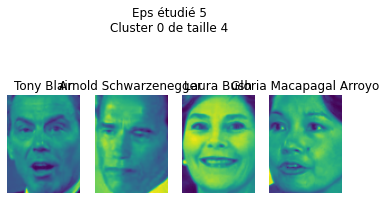

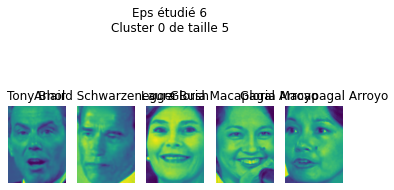

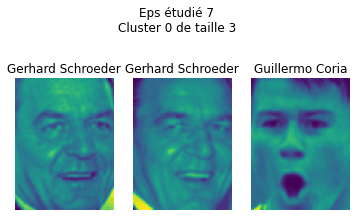

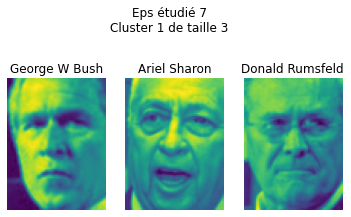

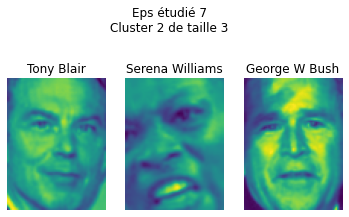

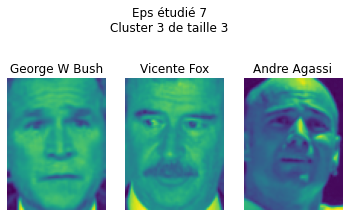

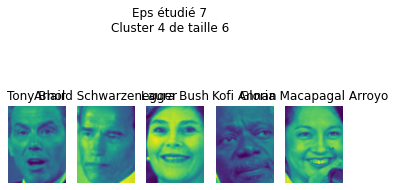

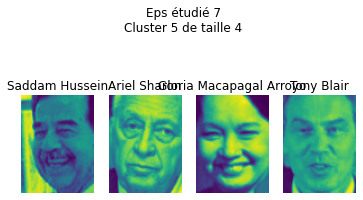

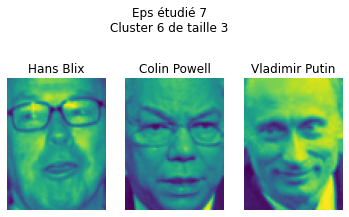

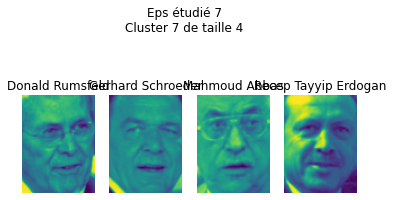

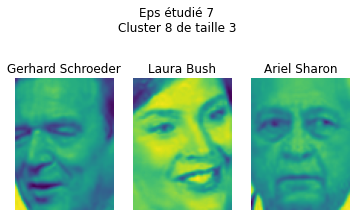

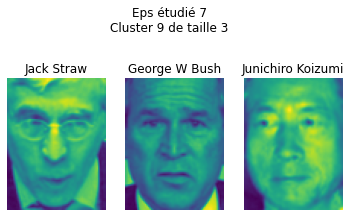

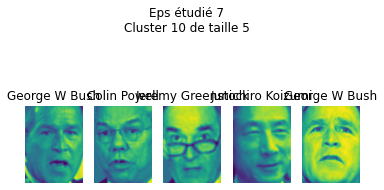

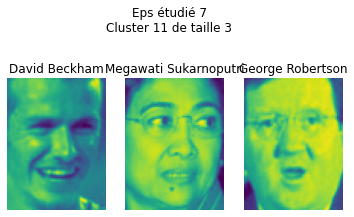

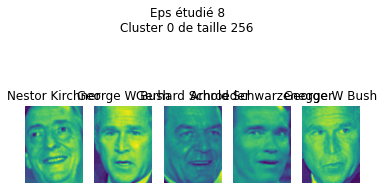

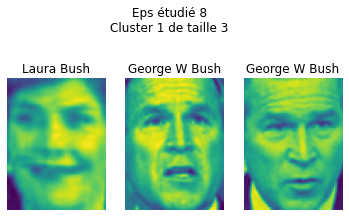

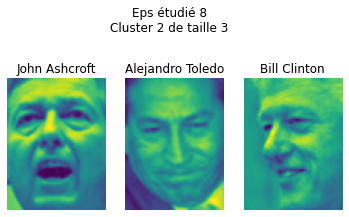

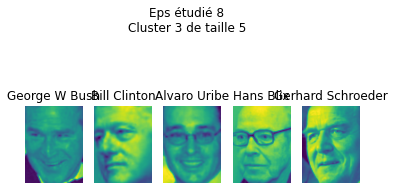

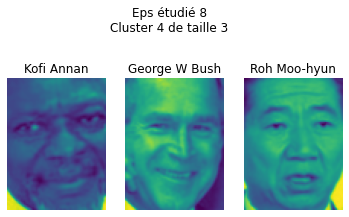

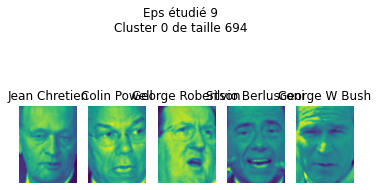

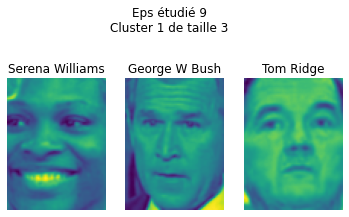

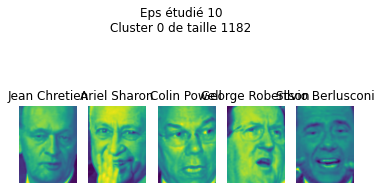

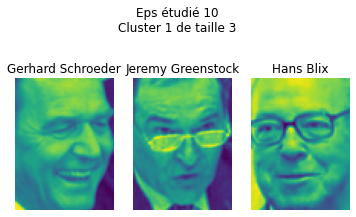

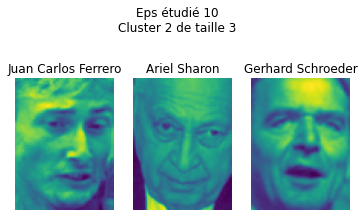

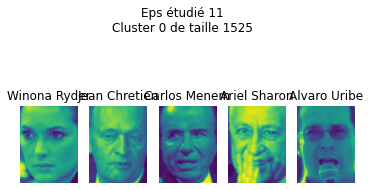

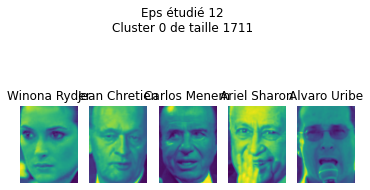

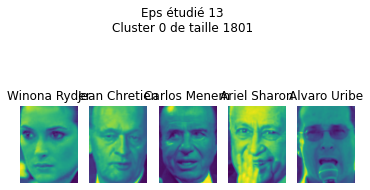

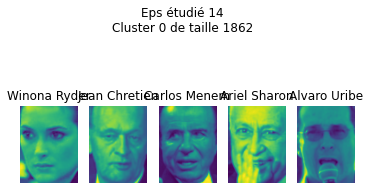

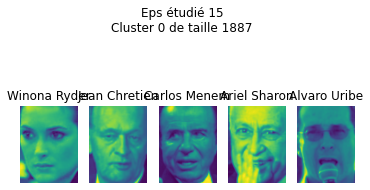

In [17]:

min_samples = 3

for eps in range(5, 16):
    pred = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit_predict(reduced_data, filtered_target)
    for label in np.unique(pred):
        if label == -1:  # cluster -1 (noise) not considered
            continue

        pred_for_label = np.where(pred == label)[0]
        clusters_images, clusters_names = [], []
        for i, p in enumerate(pred_for_label):
            if i >= 5:
                break
            clusters_images.append(faces.images[p])
            clusters_names.append(faces.target_names[faces.target[p]])

        fig, axs = plt.subplots(nrows=1, ncols=len(clusters_images))
        for img, name, ax in zip(clusters_images, clusters_names, axs):
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(name)
        fig.suptitle(f'Eps étudié {eps}\nCluster {label} de taille {len(pred_for_label)}')
        plt.show()

### Eps de 11 à 14
Les photos ressortant sont exactement les mêmes, cela s'explique évidemment par le fait qu'il n'y a qu'un seul cluster 
contenant quasiment toutes les photos.

### Eps 10
On peut dénoter que le cluster 2 présente des photos où les personnes ont la bouche ouverte. Cela peut être une 
caractéristique du cluster.
Le cluster 1 présente des photos de personnes avec des lunettes.
Les clusters 1 et 2 présentent un nombre réduit de photos alors que le cluster 0 présentent l'ensemble des photos 
restantes. On ne s'attend pas à observer de caractéristiques particulières dans le cluster 0.

### Eps 9
Le cluster 1 présente 3 photos dont la caractéristique similaire pourrait être le nez des personnes, dont l'ombre est 
assez prononcé. 
Le cluster 0 regroupe ensuite toutes les photos restantes donc ne présente à priori pas de caractéristique particulière

### Eps 8
Pour l'eps 8, on remarque que le cluster 1 présente deux photos pour la même cible "George W Bush". Les 3 photos du
cluster présentent une luminosité similaire.
Le cluster 2 montre des personnes présentant plusieurs caractéristiques similaires (rides, bouches ouverte, cernes).
Le cluster 4 présente des photos à la luminosité plus sombres. 
Le cluster 0 regroupe un nombre important de photos, les caractéristiques sont peut être plus difficiles à déterminer.

Les clusters formés par le modèle semblent logiques, présentant des caractéristiques communes pour chacune des photos. 

### Eps 7
Le cluster 0 présente des photos de la même cible, aussi, les photos présentent une luminosité sombre.
Le cluster 1 montre des photos avec de nombreuses caractéristiques physiques (cernes, rides). Elles présentent également
une luminosité assez claire.
Le cluster 6 présente des personnes avec des lunettes ou un cercle sombre autour des yeux. 

De manière générale, les clusters formés présentent des caractéristiques plus ou moins notables. Le modèle semble 
présenter des clusters plutôt logiques.

## Eps 6
Les photos du cluster 0 présentent une luminosité similaire.

## Eps 5
Les photos du cluster 0 présentent une luminosité similaire.


## Conclusion
Pour un min_samples à 3, on remarque une grande variation de clustering pour des données différentes d'epsilon. 
Pour des eps 5 et 6, le clustering est principalement du bruit et les autres clusters trouvés ne sont pas très 
significatifs.
Les eps 7 et 8 sont ceux qui présentent des résultats les plus satisfaisants, avec parfois une reconnaissance des 
cibles, et des caractérisques assez prononcées. 
À partir de eps 9, le modèle semble avoir beaucoup plus de mal à déterminer des clusters logiques. Enfin les clusters
11 à 14 présentent simplement du bruit étant donné que les cluters regroupent quasiment toutes les photos.

La vérification manuelle des clusters s'est révélée importante dans notre cas, car le modèle qui présentait le meilleur
score (démontré à la question précédente) qui était celui utilisant un eps 13, ne présente finalement pas de cluster
vraiment intéressant. Contrairement aux clusters trouvés par eps 7 et 8. 